In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pymc as pm
import pymc.sampling_jax
import pytensor.tensor as pt

/home/tomas/anaconda3/envs/bambi_hsgp/lib/python3.10/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [2]:
data = pd.read_csv("gam_data.csv")
data.head()[["x2", "y", "fac"]]

,x2,y,fac
0,0.497183,3.085274,3
1,0.196003,-2.250410,2
2,0.958474,0.070548,3
3,0.972759,-0.230454,1
4,0.755836,2.173497,2


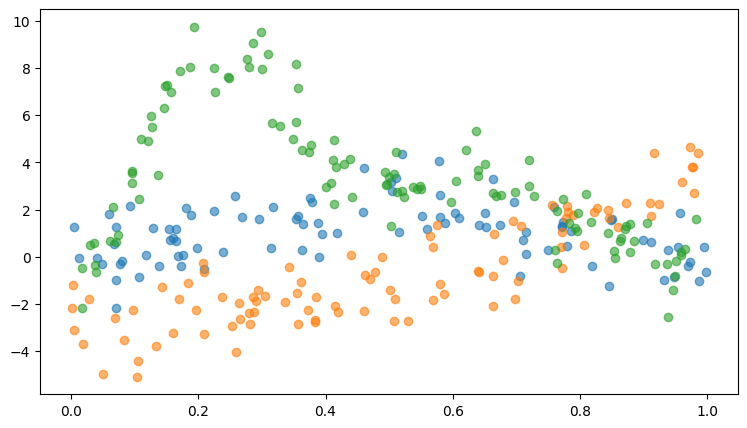

In [3]:
fig, ax = plt.subplots(figsize = (9, 5))

for i, (group, dat) in enumerate(data.groupby("fac")):
    ax.scatter(dat["x2"], dat["y"], color=f"C{i}", alpha=0.6)

In [4]:
hsgp_by, _ = np.unique(data["fac"], return_inverse=True)

coords = {
    "hsgp_by": hsgp_by,
    "hsgp_weight_dim": np.arange(10),
    "response_dim": np.arange(data.shape[0])
}

In [4]:
hsgp_by, _ = np.unique(data["fac"], return_inverse=True)

coords = {
    "hsgp_by": hsgp_by,
    "hsgp_weight_dim": np.arange(10),
    "response_dim": np.arange(data.shape[0])
}

indexes_to_unsort = data["fac"].to_numpy().argsort(kind="mergesort").argsort(kind="mergesort")

with pm.Model(coords=coords) as model:
    eta = pm.Exponential("eta", lam=3)
    ell = pm.Exponential("ell", lam=3)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    hsgp = pm.gp.HSGP(m=[10], L=[1.5], cov_func=cov)

    sqrt_psd_list = []
    phi_list = []

    for group, dat in data.groupby("fac"):
        center = dat["x2"].to_numpy().mean()
        phi_, sqrt_psd = hsgp.prior_linearized(dat["x2"].to_numpy()[:, None] - center)
        sqrt_psd_list.append(sqrt_psd)
        phi_list.append(phi_)

    sqrt_psd = pt.stack(sqrt_psd_list, axis=1)
    beta = pm.Normal("hsgp_weights", sigma=sqrt_psd, dims=("hsgp_weight_dim", "hsgp_by"))

    contribution_list = []
    for i in range(3):
        contribution_list.append(phi_list[i] @ beta[:, i])
    
    contribution = pt.concatenate(contribution_list)
    f = pm.Deterministic("f", contribution[indexes_to_unsort], dims=("response_dim", ))

    sigma = pm.HalfNormal("sigma", sigma=1)
    pm.Normal("response", mu=f, sigma=sigma, observed=data["y"], dims=("response_dim", ))

In [5]:
phi_.eval().shape

(113, 10)

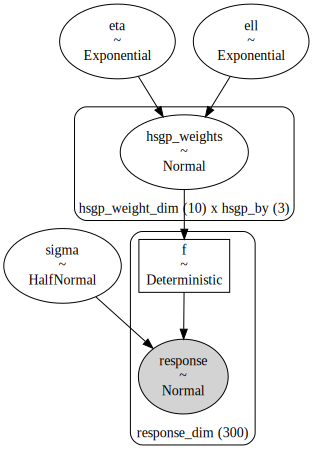

In [6]:
pm.model_to_graphviz(model)

In [7]:
with model:
        idata = pm.sampling_jax.sample_numpyro_nuts(target_accept=0.9)
print(idata.sample_stats.diverging.sum())

Compiling...


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compilation time =  0:00:04.530391
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:06.956207
Transforming variables...
Transformation time =  0:00:00.572392
<xarray.DataArray 'diverging' ()>
array(0)


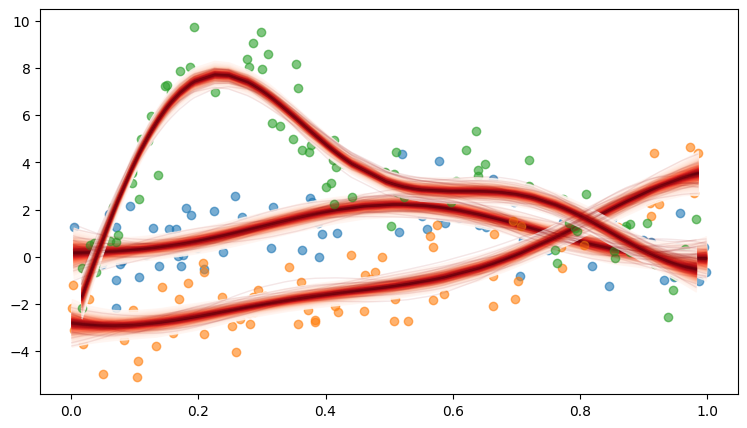

In [8]:
fig, ax = plt.subplots(figsize = (9, 5))
ff = az.extract(idata, "posterior", var_names=["f"]).to_numpy().T
for i, (group, dat) in enumerate(data.groupby("fac")):
    index = dat.index.to_numpy()
    index = index[np.argsort(dat["x2"]).to_numpy()]
    ax.scatter(dat["x2"], dat["y"], color=f"C{i}", alpha=0.6)
    pm.gp.util.plot_gp_dist(ax, ff[:, index], np.sort(dat["x2"].to_numpy()));

In [ ]:
import scipy
import pytensor

In [39]:
with pm.Model(coords=coords) as model:
    eta = pm.Exponential("eta", lam=3)
    ell = pm.Exponential("ell", lam=3)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    hsgp = pm.gp.HSGP(m=[10], L=[1.5], cov_func=cov)

    sqrt_psd_list = []
    phi_list = []

    for group, dat in data.groupby("fac"):
        center = dat["x2"].to_numpy().mean()
        phi, sqrt_psd = hsgp.prior_linearized(data["x2"].to_numpy()[:, None] - center)
        sqrt_psd_list.append(sqrt_psd)
        phi_ = phi.eval()
        phi_[data.index.difference(dat.index)] = 0
        phi_list.append(phi_)
    
    sqrt_psd = pt.stack(sqrt_psd_list, axis=1)
    beta = pm.Normal("hsgp_weights", sigma=sqrt_psd, dims=("hsgp_weight_dim", "hsgp_by"))
    beta_f = beta.T.flatten()

    phi_sparse = scipy.sparse.hstack([scipy.sparse.csr_matrix(phi) for phi in phi_list])
    phi_sparse_pt = pytensor.sparse.as_sparse_variable(phi_sparse)
    f = pm.Deterministic(
        "f", phi_sparse_pt.dot(beta_f[:, np.newaxis]).squeeze(), 
        dims=("response_dim", )
    )

    #phi = np.hstack(phi_list)
    #f = pm.Deterministic("f", phi @ beta_f, dims=("response_dim", ))

    sigma = pm.HalfNormal("sigma", sigma=1)
    pm.Normal("response", mu=f, sigma=sigma, observed=data["y"], dims=("response_dim", ))

In [41]:
with model:
        #idata = pm.sampling_jax.sample_numpyro_nuts(target_accept=0.9)
        idata = pm.sample(target_accept=0.9)
print(idata.sample_stats.diverging.sum())

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 80 seconds.


<xarray.DataArray 'diverging' ()>
array(0)


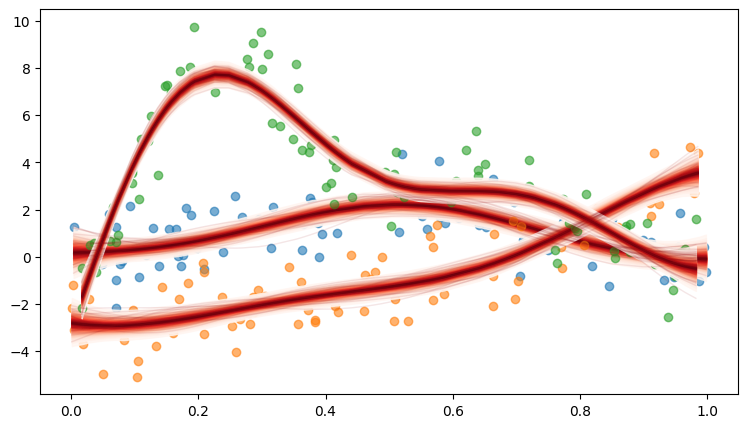

In [7]:
fig, ax = plt.subplots(figsize = (9, 5))
ff = az.extract(idata, "posterior", var_names=["f"]).to_numpy().T
for i, (group, dat) in enumerate(data.groupby("fac")):
    index = dat.index.to_numpy()
    index = index[np.argsort(dat["x2"]).to_numpy()]
    ax.scatter(dat["x2"], dat["y"], color=f"C{i}", alpha=0.6)
    pm.gp.util.plot_gp_dist(ax, ff[:, index], np.sort(dat["x2"].to_numpy()));

In [42]:
with pm.Model(coords=coords) as model:
    eta = pm.Exponential("eta", lam=3)
    ell = pm.Exponential("ell", lam=3)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    hsgp = pm.gp.HSGP(m=[10], L=[1.5], cov_func=cov)

    sqrt_psd_list = []
    phi_list = []

    for group, dat in data.groupby("fac"):
        center = dat["x2"].to_numpy().mean()
        phi, sqrt_psd = hsgp.prior_linearized(data["x2"].to_numpy()[:, None] - center)
        sqrt_psd_list.append(sqrt_psd)
        phi_ = phi.eval()
        phi_[data.index.difference(dat.index)] = 0
        phi_list.append(phi_)
    
    sqrt_psd = pt.stack(sqrt_psd_list, axis=1)
    phi = np.hstack(phi_list)
    
    beta = pm.Normal("hsgp_weights", sigma=sqrt_psd, dims=("hsgp_weight_dim", "hsgp_by"))
    beta_f = beta.T.flatten()

    f = pm.Deterministic("f", phi @ beta_f, dims=("response_dim", ))

    sigma = pm.HalfNormal("sigma", sigma=1)
    pm.Normal("response", mu=f, sigma=sigma, observed=data["y"], dims=("response_dim", ))

In [43]:
with model:
        idata = pm.sample(target_accept=0.9)
print(idata.sample_stats.diverging.sum())

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 60 seconds.


<xarray.DataArray 'diverging' ()>
array(0)


**Notes**

* We _could_ go sparse with

```python
    phi_sparse = scipy.sparse.hstack([scipy.sparse.csr_matrix(phi) for phi in phi_list])
    phi_sparse_pt = pytensor.sparse.as_sparse_variable(phi_sparse)
    f = pm.Deterministic(
        "f", phi_sparse_pt.dot(beta_f[:, np.newaxis]).squeeze(), 
        dims=("response_dim", )
    )
```

but it's not supported by JAX right now